# Setup

In [ ]:
%pip install tensorflow tensorboard

In [61]:
%pip install faiss-gpu

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 85.5 MB 6.0 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [41]:
%pip install torchattacks

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 154 kB 5.9 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
%load_ext autoreload
%autoreload 2

# Dataloader & Dataset Visualization

In [2]:
import torch
import matplotlib.pyplot as plt

from copy import deepcopy
from torchvision import transforms
from torch.utils.data import DataLoader
from dataset import MVTecAT, Repeat, CutPasteMVTecAD
from cutpaste import CutPasteUnion, CutPaste3Way

In [3]:
class Args:
    def __init__(self) -> None:
        self.min_scale = 1
        self.size = 50
        self.cutpate_type = CutPasteUnion
        self.batch_size = 64
        self.workers = 8
        self.root_dir = '/sinergia/shabanza/datasets/mvtec'
        self.head_layer = 2
        self.data_type = 'grid'
        self.learninig_rate = 0.03
        self.epochs = 256
        self.pretrained = True
        self.freeze_net = 20
        self.optim = 'sgd'


args = Args()

## DataLoaders

- trainloader: Returns good + cutpaste Images ([0] is image (original or cutpaste), [1] is label)
- testloader: Returns images (good or bad in real dataset) + labels (good / bad)

In [4]:
from copy import deepcopy
from typing import Tuple, List

def get_ds_transforms(args) -> List[transforms.Compose]:
    train_transform = transforms.Compose([
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.Resize((args.size, args.size))
    ])
    
    after_cutpaste_transform = transforms.Compose([
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    train_cutpaste_transform = deepcopy(train_transform)
    train_cutpaste_transform.transforms.append(args.cutpate_type(transform=after_cutpaste_transform))
    train_transform.transforms.extend([
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    test_transform = transforms.Compose([
        transforms.Resize((args.size, args.size)),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    return train_transform, train_cutpaste_transform, test_transform

In [5]:
def get_dataloaders(args) -> List[DataLoader]:
    size = int(args.size * (1/args.min_scale))
    train_transform, train_cutpaste_transform, test_transform = get_ds_transforms(args)
    train_ds_normal = MVTecAT(
        args.root_dir, args.data_type, transform=train_transform, size=size, mode="train"
    )
    train_ds_anomal = CutPasteMVTecAD(
        args.root_dir, args.data_type, transform=train_cutpaste_transform, size=size, mode="train"
    )
    train_ds = torch.utils.data.ConcatDataset([train_ds_normal, train_ds_anomal])

    train_dataloader = DataLoader(
        Repeat(train_ds, 3000), batch_size=args.batch_size, drop_last=True,
        shuffle=True, num_workers=args.workers, persistent_workers=True, 
        pin_memory=True, prefetch_factor=5
    )

    train_dataloader_normal = DataLoader(
        Repeat(train_ds_normal, 3000), batch_size=args.batch_size, drop_last=True,
        shuffle=True, num_workers=args.workers, persistent_workers=True, 
        pin_memory=True, prefetch_factor=5
    )
    
    test_ds = MVTecAT(
        args.root_dir, args.data_type, args.size, transform=test_transform, mode="test"
    )
    test_dataloader = DataLoader(test_ds, batch_size=args.batch_size, shuffle=False, num_workers=0)
    
    return train_dataloader, train_dataloader_normal, test_dataloader

In [6]:
train_dataloader, train_dataloader_normal, test_dataloader = get_dataloaders(args)

loading images


loaded 264 images
loading images
loaded 264 images


## Visualize

In [7]:
def visualize(sample_images, labels):
    # Convert the tensor to numpy array
    sample_images_np = sample_images.numpy()

    # Reshape the tensor to [num_samples, 256, 256, 3] for visualization
    sample_images_np = sample_images_np.transpose(0, 2, 3, 1)

    _, axes = plt.subplots(1, sample_images_np.shape[0], figsize=(15, 3))
    for i, ax in enumerate(axes):
        ax.imshow(sample_images_np[i])
        ax.set_title('anomal' if labels[i] else 'normal')
        ax.axis('off')

    plt.show()

In [8]:
num_samples = 5
sample_indices = torch.randperm(args.batch_size)[:num_samples]

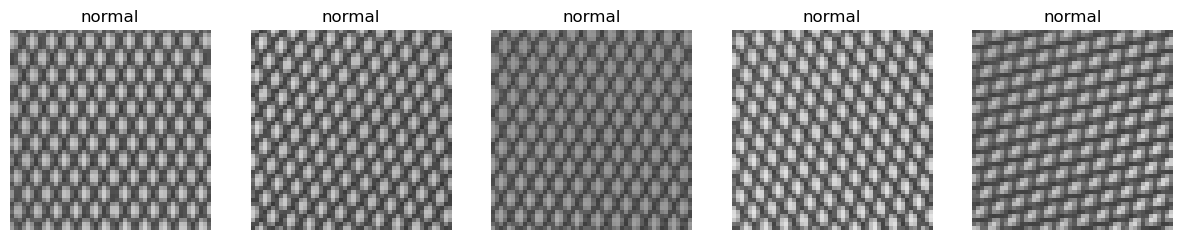

In [9]:
# visualize normal

images, labels = next(iter(train_dataloader_normal))
visualize(images[sample_indices], labels[sample_indices])

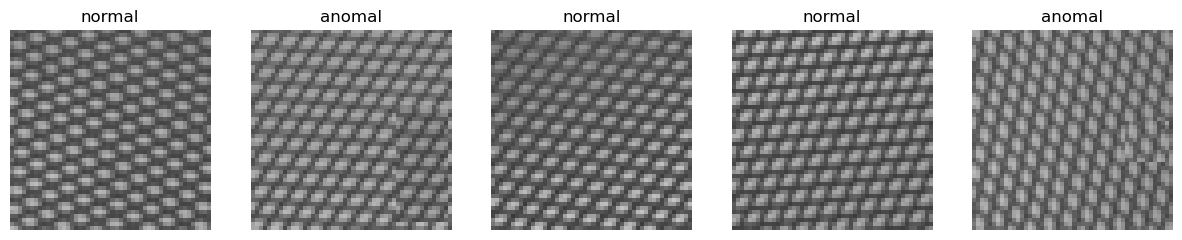

In [10]:
# visualize normal + cutpaste

images, labels = next(iter(train_dataloader))
visualize(images[sample_indices], labels[sample_indices])

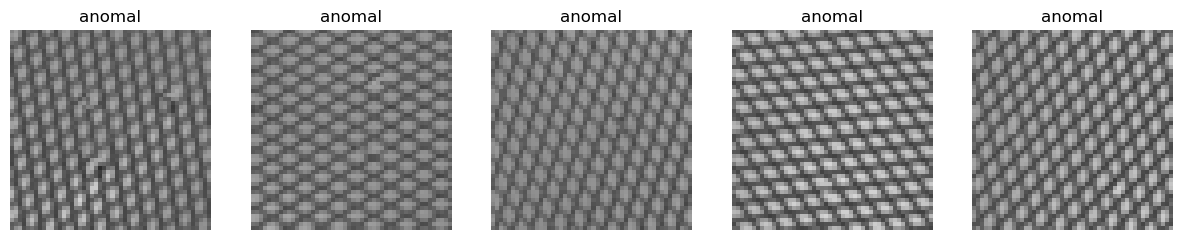

In [11]:
# visualize test

images, labels = next(iter(test_dataloader))
visualize(images[sample_indices], labels[sample_indices])

# Train

In [12]:
import sys
import datetime
import numpy as np
import torch.optim as optim
from sklearn import metrics
import time
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from model import ProjectionNet
from utils import save_checkpoint, load_checkpoint

In [13]:
def train(model, loader, loss_fn, optimizer, device):
    """ training one epoch and calculate loss and metrics """
    # Training model
    model.train()
    losses = 0.0
    steps = len(loader)
    correct = 0.0
    total = 0.0
    which_class = 1
    preds = []
    targs = []
    softmax = torch.nn.Softmax(dim=1)
    for i, (inputs, targets) in enumerate(loader):
        # Place to gpu
        inputs = inputs.to(device)
        targets = targets.to(torch.int64).to(device)

        # Forward pass
        outputs, _ = model(inputs)
        
        # Calculate loss
        loss = loss_fn(outputs, targets)
        losses += loss

        # Backpropagation and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        # Calculate metrics
        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()
        total += targets.size(0)

        probs = softmax(outputs).squeeze()
        preds.append(probs[:, which_class].detach().cpu())
        targs.append((targets.cpu()==which_class)*1.0)

        # report
        sys.stdout.flush()
        sys.stdout.write('\r Step: [%2d/%2d], loss: %.4f - acc: %.4f'
                          % (i, steps, targets.size(0)*losses.item()/total, 100.0*correct/total))
    sys.stdout.write ('\r')

    preds = torch.cat(preds).numpy()
    targs = torch.cat(targs).numpy()
    fpr, tpr, thresholds = metrics.roc_curve(targs, preds)
    train_auc = metrics.auc(fpr, tpr)

    return train_auc, losses.item()/total, 100.0*correct/total


In [20]:
def build_model(args, device):
    head_layers = [512]*args.head_layer+[128]
    num_classes = 2 if args.cutpate_type is not CutPaste3Way else 3
    model = ProjectionNet(pretrained=args.pretrained, head_layers=head_layers, num_classes=num_classes)
    model.to(device)

    if args.freeze_net > 0 and args.pretrained:
        model.freeze_resnet()

    return model

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
weight_decay = 0.00003
momentum = 0.9


model = build_model(args, device)
loss_fn = torch.nn.CrossEntropyLoss()
if args.optim == "sgd":
    optimizer = optim.SGD(model.parameters(), lr=args.learninig_rate, momentum=momentum,  weight_decay=weight_decay)
    scheduler = CosineAnnealingWarmRestarts(optimizer, args.epochs)
elif args.optim == "adam":
    optimizer = optim.Adam(model.parameters(), lr=args.learninig_rate, weight_decay=weight_decay)
    scheduler = None

# Evaluate

In [16]:
import faiss
from sklearn.metrics import roc_auc_score

def knn_score(train_set, test_set, n_neighbours=2):
    """
    Calculates the KNN distance
    """
    index = faiss.IndexFlatL2(train_set.shape[1])
    index.add(train_set)
    D, _ = index.search(test_set, n_neighbours)
    return np.sum(D, axis=1)


def knn_evaluate(model, test_loader, train_loader_normal, loss_fn, device):
    """ Evaluate trained weights using calculate loss and metrics """
    model.eval ()
    softmax = torch.nn.Softmax(dim=1)
    test_feature_space = []
    test_labels = []
    train_feature_space = []
    with torch.no_grad ():
        for inputs, targets in test_loader:
            '''
            activation = {}
            def get_activation(name):
                def hook(model, input, output):
                    activation[name] = output.detach()
                return hook
            m.model.heads.head.register_forward_hook(get_activation('feature'))
            '''
            inputs = inputs.to(device)
            targets = targets.to(torch.int64).to(device)
            outputs, features = model(inputs)
            test_feature_space.append(features)
            test_labels.append(targets.detach().cpu())

        for inputs, targets in train_loader_normal:
            '''
            activation = {}
            def get_activation(name):
                def hook(model, input, output):
                    activation[name] = output.detach()
                return hook
            m.model.heads.head.register_forward_hook(get_activation('feature'))
            '''
            inputs = inputs.to(device)
            targets = targets.to(torch.int64).to(device)
            outputs, features = model(inputs)
            train_feature_space.append(features)

    test_labels = torch.cat(test_labels, dim=0).cpu().numpy()
    test_feature_space = torch.cat(test_feature_space, dim=0).contiguous().cpu().numpy()
    train_feature_space = torch.cat(train_feature_space, dim=0).contiguous().cpu().numpy()

    distances = knn_score(train_feature_space, test_feature_space)
    auc = roc_auc_score(test_labels, distances)
    return auc, distances, test_labels

In [83]:
def evaluate(model, loader, loss_fn, device, attack=False, adversary=None):
    """ Evaluate trained weights using calculate loss and metrics """
    model.eval()
    losses = 0.0
    steps = len(loader)
    correct = 0.0
    total = 0.0
    which_class = 1
    preds = []
    targs = []
    softmax = torch.nn.Softmax(dim=1)

    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            targets = targets.to(torch.int64).to(device)
    
            if attack:
                with torch.enable_grad():
                    inputs = adversary(inputs, targets)
                    torch.no_grad()

            outputs, _ = model(inputs)
            loss = loss_fn(outputs, targets)
            losses += loss

            _, predicted = outputs.max(1)
            correct += predicted.eq(targets).sum().item()
            total += targets.size(0)

            probs = softmax(outputs).squeeze()
            preds.append(probs[:, which_class].detach().cpu())
            targs.append((targets.cpu()==which_class)*1.0)

    preds = torch.cat(preds).numpy()
    targs = torch.cat(targs).numpy()
    fpr, tpr, thresholds = metrics.roc_curve(targs, preds)
    eval_auc = metrics.auc(fpr, tpr)

    return eval_auc, losses.item()/total, 100.0*correct/total, preds, targs

# Attacks

In [93]:
class CustomPGD:
    def __init__(self, model, eps=8/255, alpha=2/255, steps=10, random_start=True):
        self.model = model
        self.eps = eps
        self.alpha = alpha
        self.steps = steps
        self.random_start = random_start
    
    def __call__(self, images, labels):
        return self.forward(images, labels)
    
    def forward(self, images, labels):
        images = images.clone()
        labels = labels.clone()
        loss = torch.nn.CrossEntropyLoss()
        adv_images = images.clone().detach()
        
        if self.random_start:
            adv_images = adv_images + torch.empty_like(adv_images).uniform_(-self.eps, self.eps)
            adv_images = torch.clamp(adv_images, min=0, max=1).detach()

        for _ in range(self.steps):
            adv_images.requires_grad = True
            outputs, _ = model(adv_images)

            # Calculate loss
            cost = loss(outputs, labels)

            # Update adversarial images
            grad = torch.autograd.grad(cost, adv_images,
                                       retain_graph=False, create_graph=False)[0]

            adv_images = adv_images.detach() + self.alpha*grad.sign()
            delta = torch.clamp(adv_images - images, min=-self.eps, max=self.eps)
            adv_images = torch.clamp(images + delta, min=0, max=1).detach()
        
        return adv_images.clone()

# Run

In [27]:
def fit(model, train_dl, valid_dl, train_loader_normal, loss_fn, optimizer, num_epochs, device, scheduler=None, checkpoint_path=None):
    """ fiting model to dataloaders, saving best weights and showing results """
    losses, val_losses, accs, val_accs, auces, val_auces, val_auces_knn, val_auces_msp_knn = [], [], [], [], [], [], [], []
    best_auc = 0.0

    since = time.time ()
    for epoch in range (num_epochs):
        if epoch == args.freeze_net:
            model.unfreeze()
        train_auc, loss, acc = train(model, train_dl, loss_fn, optimizer, device)
        val_auc, val_loss, val_acc, preds, targs = evaluate(model, valid_dl, loss_fn, device)
        val_auc_knn, distances, _ = knn_evaluate(model, valid_dl, train_loader_normal, loss_fn, device)

        out = preds + (distances / np.linalg.norm(distances))
        fpr, tpr, thresholds = metrics.roc_curve(targs, out)
        msp_knn_auc = metrics.auc(fpr, tpr)

        losses.append(loss)
        accs.append(acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        auces.append(train_auc)
        val_auces.append(val_auc)
        val_auces_knn.append(val_auc_knn)
        val_auces_msp_knn.append(msp_knn_auc)

        # learning rate scheduler
        if scheduler is not None:
            scheduler.step(val_auc)

        # save weights if improved
        if val_auc > best_auc:
            checkpoint = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
            save_checkpoint(checkpoint, checkpoint_path)
            best_auc = val_auc

        print ('Epoch [{}/{}], loss: {:.4f} - auc: {:.4f} |\n val_loss: {:.4f} - val_acc: {:.4f} - val_auc_msp: {:.4f} - val_auc_knn: {:.4f} - val_auc_knn_msp: {:.4f}'
               .format(epoch + 1, num_epochs, loss, train_auc, val_loss, val_acc, val_auc, val_auc_knn, msp_knn_auc))

    period = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format (period // 60, period % 60))

    return dict(loss=losses, val_loss=val_losses, acc=accs, val_acc=val_accs, auces=auces, val_auces=val_auces, val_auces_knn=val_auces_knn, val_auces_msp_knn=val_auces_msp_knn)


In [28]:
def plot_metrics(val_auc_knn, val_auc, val_auc_knn_msp):
    """ ploting each of metric in one line """

    # fig, ax = plt.subplots (1, 1, figsize = (20, 5))
    plt.plot(range(len(val_auc_knn)), val_auc_knn, 'b-', label='Val_AUC_KNN')
    plt.plot(range(len(val_auc)), val_auc, 'r-', label='Val_AUC_MSP')
    plt.plot(range(len(val_auc_knn_msp)), val_auc_knn_msp, 'g-', label='Val_AUC_KNN_MSP')
    plt.title('AUC')
    plt.legend()
    plt.show()

In [29]:
def run(args):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    weight_decay = 0.00003
    momentum = 0.9
    train_dataloader, train_dataloader_normal, test_dataloader = get_dataloaders(args)
    model = build_model(args, device)
    loss_fn = torch.nn.CrossEntropyLoss()
    if args.optim == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=args.learninig_rate, momentum=momentum,  weight_decay=weight_decay)
        scheduler = CosineAnnealingWarmRestarts(optimizer, args.epochs)
        #scheduler = None
    elif args.optim == "adam":
        optimizer = optim.Adam(model.parameters(), lr=args.learninig_rate, weight_decay=weight_decay)
        scheduler = None
    
    history = fit(
        model=model, 
        train_dl=train_dataloader, 
        valid_dl=test_dataloader, 
        train_loader_normal=train_dataloader_normal, 
        loss_fn=loss_fn, optimizer=optimizer, 
        num_epochs=args.epochs, device=device, 
        scheduler=scheduler,
        checkpoint_path=f'../models/model_{args.data_type}' + '_{date:%Y-%m-%d_%H_%M_%S}.pth'.format(date=datetime.datetime.now())
    )
    plot_metrics(history["val_auces_knn"], history["val_auces"], history["val_auces_msp_knn"])

## Carpet

In [99]:
args.data_type = 'carpet'
args.epochs = 100
run(args)

loading images


loaded 280 images
loading images
loaded 280 images
=> saving checkpoint: 0.7353 - acc: 52.1060
Epoch [1/100], loss: 0.0115 - auc: 0.5070 |
 val_loss: 0.0145 - val_acc: 23.9316 - val_auc_msp: 0.8070 - val_auc_knn: 0.6878 - val_auc_knn_msp: 0.8110
Epoch [2/100], loss: 0.0109 - auc: 0.5589 |
 val_loss: 0.0974 - val_acc: 76.0684 - val_auc_msp: 0.5000 - val_auc_knn: 0.6738 - val_auc_knn_msp: 0.6738
Epoch [3/100], loss: 0.0104 - auc: 0.6407 |
 val_loss: 0.0432 - val_acc: 76.0684 - val_auc_msp: 0.7135 - val_auc_knn: 0.5457 - val_auc_knn_msp: 0.5457
=> saving checkpoint: 0.6242 - acc: 65.3872
Epoch [4/100], loss: 0.0098 - auc: 0.6829 |
 val_loss: 0.0114 - val_acc: 76.0684 - val_auc_msp: 0.8170 - val_auc_knn: 0.8170 - val_auc_knn_msp: 0.8102
Epoch [5/100], loss: 0.0093 - auc: 0.7210 |
 val_loss: 0.0124 - val_acc: 76.0684 - val_auc_msp: 0.7283 - val_auc_knn: 0.7235 - val_auc_knn_msp: 0.7283
Epoch [6/100], loss: 0.0091 - auc: 0.7235 |
 val_loss: 0.0499 - val_acc: 76.0684 - val_auc_msp: 0.5441 - v

### Evaluate Standard

In [ ]:
model = build_model(args, device)
checkpoint_path = '../models/model_grid_2023-09-26_10_17_23.pth'
load_checkpoint(checkpoint_path, model)

In [ ]:
val_auc, val_loss, val_acc, preds, targs = evaluate(model, test_dataloader, loss_fn, device)

print('Val AUC: ', val_auc)
print('Val ACC: ', val_acc)
print('Val Loss: ', val_loss)
print(preds, targs)

### Evaluate PGD Attack

In [ ]:
adversary = CustomPGD(model, eps=8/255, alpha=1/255, steps=40, random_start=True)

In [ ]:
val_auc, val_loss, val_acc, preds, targs = evaluate(model, test_dataloader, loss_fn, device, attack=True, adversary=adversary)

print('Val AUC: ', val_auc)
print('Val ACC: ', val_acc)
print('Val Loss: ', val_loss)
print(preds, targs)

## Grid

loading images
loaded 264 images
loading images
loaded 264 images
=> saving checkpoint: 0.6036 - acc: 68.5462
Epoch [1/100], loss: 0.0094 - auc: 0.7423 |
 val_loss: 0.0253 - val_acc: 43.5897 - val_auc_msp: 0.5831 - val_auc_knn: 0.6057 - val_auc_knn_msp: 0.6099
=> saving checkpoint: 0.4928 - acc: 76.1889
Epoch [2/100], loss: 0.0077 - auc: 0.8380 |
 val_loss: 0.0169 - val_acc: 58.9744 - val_auc_msp: 0.6199 - val_auc_knn: 0.5430 - val_auc_knn_msp: 0.6299
=> saving checkpoint: 0.4545 - acc: 79.0761
Epoch [3/100], loss: 0.0071 - auc: 0.8595 |
 val_loss: 0.0164 - val_acc: 61.5385 - val_auc_msp: 0.7519 - val_auc_knn: 0.5104 - val_auc_knn_msp: 0.7360
Epoch [4/100], loss: 0.0068 - auc: 0.8736 |
 val_loss: 0.0173 - val_acc: 58.9744 - val_auc_msp: 0.7277 - val_auc_knn: 0.4887 - val_auc_knn_msp: 0.7093
Epoch [5/100], loss: 0.0064 - auc: 0.8878 |
 val_loss: 0.0159 - val_acc: 67.9487 - val_auc_msp: 0.7210 - val_auc_knn: 0.5029 - val_auc_knn_msp: 0.7168
Epoch [6/100], loss: 0.0063 - auc: 0.8923 |
 va

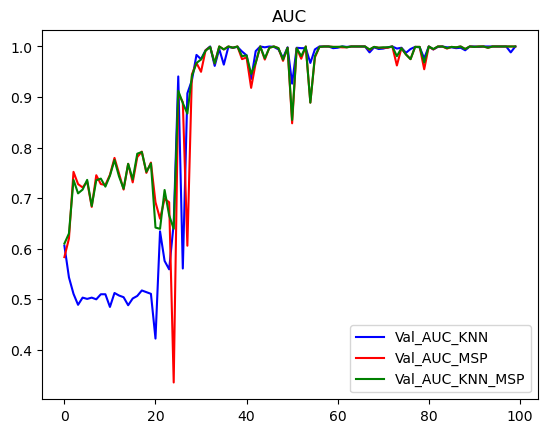

In [32]:
args.data_type = 'grid'
args.epochs = 100
run(args)

### Evaluate Standard

In [94]:
model = build_model(args, device)
checkpoint_path = '../models/model_grid_2023-09-26_10_17_23.pth'
load_checkpoint(checkpoint_path, model)

=> loading checkpoint


In [95]:
val_auc, val_loss, val_acc, preds, targs = evaluate(model, test_dataloader, loss_fn, device)

print('Val AUC: ', val_auc)
print('Val ACC: ', val_acc)
print('Val Loss: ', val_loss)
print(preds, targs)

Val AUC:  1.0
Val ACC:  96.15384615384616
Val Loss:  0.0010809028186859228
[9.8301202e-01 9.7850364e-01 9.5409769e-01 9.8446447e-01 9.9794871e-01
 9.9886703e-01 9.9790502e-01 9.9797744e-01 9.8364139e-01 9.9751222e-01
 9.9867201e-01 9.9930799e-01 9.9602282e-01 9.9969018e-01 8.8897544e-01
 9.9949658e-01 9.9296582e-01 9.9472344e-01 9.8241502e-01 9.9061489e-01
 9.1750067e-01 9.9923337e-01 9.9867141e-01 9.9825484e-01 1.5677692e-01
 9.8485881e-01 9.7103935e-01 3.4951249e-01 9.8965198e-01 9.9298602e-01
 9.5299196e-01 9.5084357e-01 3.8053879e-01 9.9337363e-01 9.0279299e-01
 2.5989320e-02 7.9117641e-02 2.6061994e-03 6.6337613e-03 3.5417065e-02
 5.6401808e-02 1.1838594e-01 4.0626351e-02 2.2198563e-02 5.5153412e-03
 6.5718986e-02 3.6436949e-02 1.5120022e-03 9.9421153e-03 2.9650214e-03
 7.8297146e-02 9.2594401e-04 4.0913597e-02 1.5482425e-02 1.0406556e-02
 1.1876644e-01 9.9931228e-01 9.9777240e-01 9.9944359e-01 9.9945527e-01
 9.9942625e-01 9.9943596e-01 9.9879634e-01 9.9921536e-01 9.9919885e-01
 9

### Evaluate PGD Attack

In [96]:
adversary = CustomPGD(model, eps=8/255, alpha=1/255, steps=40, random_start=True)

In [97]:
val_auc, val_loss, val_acc, preds, targs = evaluate(model, test_dataloader, loss_fn, device, attack=True, adversary=adversary)

print('Val AUC: ', val_auc)
print('Val ACC: ', val_acc)
print('Val Loss: ', val_loss)
print(preds, targs)

Val AUC:  0.0
Val ACC:  8.974358974358974
Val Loss:  0.12007681528727214
[8.15638399e-04 5.65028895e-05 8.59535474e-04 2.67337472e-03
 5.06016950e-04 3.85880208e-04 4.36926167e-03 2.79667485e-03
 7.93484869e-05 4.51133383e-05 2.01477553e-03 3.30028217e-03
 4.69657499e-03 1.22473486e-01 9.36346245e-04 2.55705277e-03
 2.06297540e-04 2.16672910e-04 1.23445038e-03 8.54450336e-05
 8.83288667e-05 6.44114148e-03 1.81057106e-03 5.91928186e-03
 5.03253716e-04 6.28196140e-05 9.85816005e-05 1.11560279e-04
 1.78608854e-04 8.64803093e-04 1.37806725e-04 1.34754955e-04
 5.59673754e-05 3.95836978e-04 2.70014600e-04 9.99865770e-01
 9.99904394e-01 9.99903321e-01 9.99875546e-01 9.99907970e-01
 9.99893665e-01 9.99932528e-01 9.99900103e-01 9.99906063e-01
 9.99922514e-01 9.99909639e-01 9.99897957e-01 9.99897718e-01
 9.99899268e-01 9.99922156e-01 9.99909520e-01 9.99903798e-01
 9.99923706e-01 9.99882817e-01 9.99907494e-01 9.99879599e-01
 1.33012280e-01 4.19255905e-03 4.41587605e-02 3.58890295e-01
 9.13672805e

## Cable

In [75]:
args.data_type = 'cable'
run(args)

loading images
loaded 224 images
loading images
loaded 224 images
=> saving checkpoint: 0.4057 - acc: 81.8614
Epoch [1/256], loss: 0.0063 - auc: 0.8871 |
 val_loss: 0.0222 - val_acc: 60.6667 - val_auc_msp: 0.8235 - val_auc_knn: 0.0000 - val_auc_knn_msp: 0.0000
Epoch [2/256], loss: 0.0052 - auc: 0.9257 |
 val_loss: 0.0134 - val_acc: 66.6667 - val_auc_msp: 0.8148 - val_auc_knn: 0.0000 - val_auc_knn_msp: 0.0000
=> saving checkpoint: 0.3136 - acc: 87.9416
Epoch [3/256], loss: 0.0049 - auc: 0.9300 |
 val_loss: 0.0194 - val_acc: 66.0000 - val_auc_msp: 0.8368 - val_auc_knn: 0.0000 - val_auc_knn_msp: 0.0000
=> saving checkpoint: 0.2805 - acc: 89.1304
Epoch [4/256], loss: 0.0044 - auc: 0.9440 |
 val_loss: 0.0162 - val_acc: 66.0000 - val_auc_msp: 0.8473 - val_auc_knn: 0.0000 - val_auc_knn_msp: 0.0000
Epoch [5/256], loss: 0.0044 - auc: 0.9429 |
 val_loss: 0.0122 - val_acc: 76.0000 - val_auc_msp: 0.8274 - val_auc_knn: 0.0000 - val_auc_knn_msp: 0.0000
Epoch [6/256], loss: 0.0041 - auc: 0.9504 |
 va

## Zipper

In [ ]:
args.data_type = 'zipper'
run(args)